# **Problemstellung:**
Die Diagnose von Lungenentzündung mit Röntgenaufnahmen ist schwierig, besonders bei Kindern. Ärzte brauchen viel Zeit, um die Aufnahmen zu bewerten, und die Ergebnisse können unterschiedlich ausfallen. Ein automatisches System zur Erkennung von Lungenentzündung könnte die Diagnose schneller und zuverlässiger machen.

# **Was ist eine Lungenentzündung?**

Eine Lungenentzündung ist eine Entzündung der Lunge, die durch Bakterien, Viren oder Pilze verursacht wird. Symptome sind Husten, Fieber und Atemnot. Auf Röntgenaufnahmen sieht eine bakterielle Lungenentzündung oft wie ein weißer Fleck in einem Lungenbereich aus, während eine virale Lungenentzündung eher ein verschwommenes Muster in beiden Lungen zeigt.

# **Ziel:**
Das Ziel ist es, ein automatisches System zu entwickeln, das Lungenentzündung auf Röntgenaufnahmen erkennt. Dafür wird ein Datensatz mit 5.863 Röntgenaufnahmen von Kindern (1 bis 5 Jahre) verwendet. Die Aufnahmen sind entweder normal oder zeigen eine Lungenentzündung. Das KI-Modell soll helfen, die Diagnose zu verbessern und Ärzte bei ihrer Arbeit unterstützen.



## **Import necessary functions**

In [ ]:
import pandas as pd
import glob
from imblearn.over_sampling import RandomOverSampler
import joblib
import os
import cv2
from sklearn.utils import shuffle
from numpy.random import seed
import numpy as np
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
%matplotlib inline
seed(42)
pd.options.display.max_colwidth = 100
warnings.filterwarnings('ignore')
warnings.

In [46]:
print(f"tensorflow version: {tf.__version__}")
print(f"cv version : {cv2.__version__}")

tensorflow version: 2.18.0
cv version : 4.11.0


## **Load Data from Kaggle**

In [47]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ericd\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [114]:
img_size = 224
batch_size = 32
seed = 42
chanel_nbr = 3

## **create train , test and val dataset**

## `create_datasets` Funktion Übersicht

Die Funktion `create_datasets` verarbeitet und bereitet Trainings-, Test- und Validierungsdatensätze aus einem angegebenen Verzeichnis mit Röntgenbildern vor. Sie lädt die Bilder, passt ihre Größe an, normalisiert die Pixelwerte und kennzeichnet sie als "NORMAL" oder "PNEUMONIA". Die Funktion gibt drei Pandas DataFrames zurück: `df_train`, `df_test` und `df_val`, die die Bilddaten und ihre entsprechenden Labels enthalten.

### Argumente:
- `path`: Pfad zum Verzeichnis des Datensatzes mit den Unterverzeichnissen `train`, `test` und `val`.
- `img_size`: Die Größe, auf die jedes Bild skaliert wird (Standard: `224x224`).

### Prozess:
1. **Verzeichniseinrichtung**: Die Funktion richtet Pfade für die Ordner `train`, `test` und `val` ein.
   
2. **Dateisammlung**: Sie sammelt die Bilddateien aus den Unterverzeichnissen `NORMAL` und `PNEUMONIA` für jedes der drei Datensätze.

3. **Bildverarbeitung**:
   - **Größenänderung**: Jedes Bild wird auf die angegebene Größe (`img_size`) skaliert.
   - **Normalisierung**: Die Pixelwerte werden durch den `img_size` geteilt.
   - **Labeling**: Bilder werden als `0` für normal und `1` für Pneumonie gekennzeichnet.

4. **Fehlerbehandlung**: Wenn ein Bild nicht gelesen oder verarbeitet werden kann, wird es übersprungen und eine Fehlermeldung ausgegeben.

5. **Datenzusammenstellung**: Die Bilddaten und Labels werden in einer Liste gesammelt und zu einem Pandas DataFrame verarbeitet.

6. **Rückgabe**: Die Funktion gibt die DataFrames für Trainings-, Test- und Validierungsdatensätze zurück.

### Rückgabewert:
Die Funktion gibt ein Tupel von Pandas DataFrames zurück: `(df_train, df_test, df_val)`, die jeweils folgende Spalten enthalten:
- `image`: Das bearbeitete und skalierte Bild.
- `label`: Das Label der Klasse (0 für normal, 1 für Pneumonie).

### Beispiel:
```python
df_train, df_test, df_val = create_datasets("path/to/dataset", img_size=224)


In [115]:
def create_datasets(path, img_size=224):
    """
    Creates train, test, and validation datasets with labels.

    Args:
        path: Path to the downloaded dataset.
        img_size: Size to resize images to.

    Returns:
        Tuple of pandas DataFrames: (df_train, df_test, df_val)
    """
    train_path = os.path.join(path,"chest_xray/train")
    test_path=os.path.join(path,"chest_xray/test")
    validation_path = os.path.join(path,"chest_xray/val")

    dic_data = {
        "train": [glob.glob(train_path+"/NORMAL/*.jpeg"), glob.glob(train_path+"/PNEUMONIA/*.jpeg")],
        "test": [glob.glob(test_path+"/NORMAL/*.jpeg"), glob.glob(test_path+"/PNEUMONIA/*.jpeg")],
        "val": [glob.glob(validation_path+"/NORMAL/*.jpeg"), glob.glob(validation_path+"/PNEUMONIA/*.jpeg")]
    }

    datasets = {}
    for key, value in dic_data.items():
        classes = [0]*len(value[0])    # Normal : 0 and Pneunomia : 1
        classes.extend([1]*len(value[1]))
        images_path = value[0] + value[1]
        data = []
        for i, img_path in enumerate(images_path):
          try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if chanel_nbr == 3:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            if img is None:
              continue
            img = cv2.resize(img, (img_size, img_size))
            img = img/img_size
            data.append([img, classes[i]])
          except Exception as e:
            print(f"Error processing {img_path}: {e}")

        datasets[key] = pd.DataFrame(data, columns=['image', 'label'])

    return datasets["train"], datasets["test"], datasets["val"]

In [116]:
df_train, df_test, df_val = create_datasets(path)

## **Histogram**

## `plot_label_distribution` Funktion Übersicht

Die Funktion `plot_label_distribution` zeigt die Verteilung der Klassenlabels (NORMAL und PNEUMONIA) für die Trainings-, Test- und Validierungsdatensätze in Form von Balkendiagrammen an.

### Prozess:
1. Die Funktion erstellt eine Subplot-Darstellung mit drei Diagrammen (je eines für Training, Test und Validierung).
2. Für jedes Dataset wird die Anzahl der Instanzen jeder Klasse (NORMAL und PNEUMONIA) gezählt und als Balkendiagramm angezeigt.
3. Die Achsenbeschriftungen und Titel werden entsprechend angepasst.

### Beispiel:
```python
plot_label_distribution(df_train, df_test, df_val)


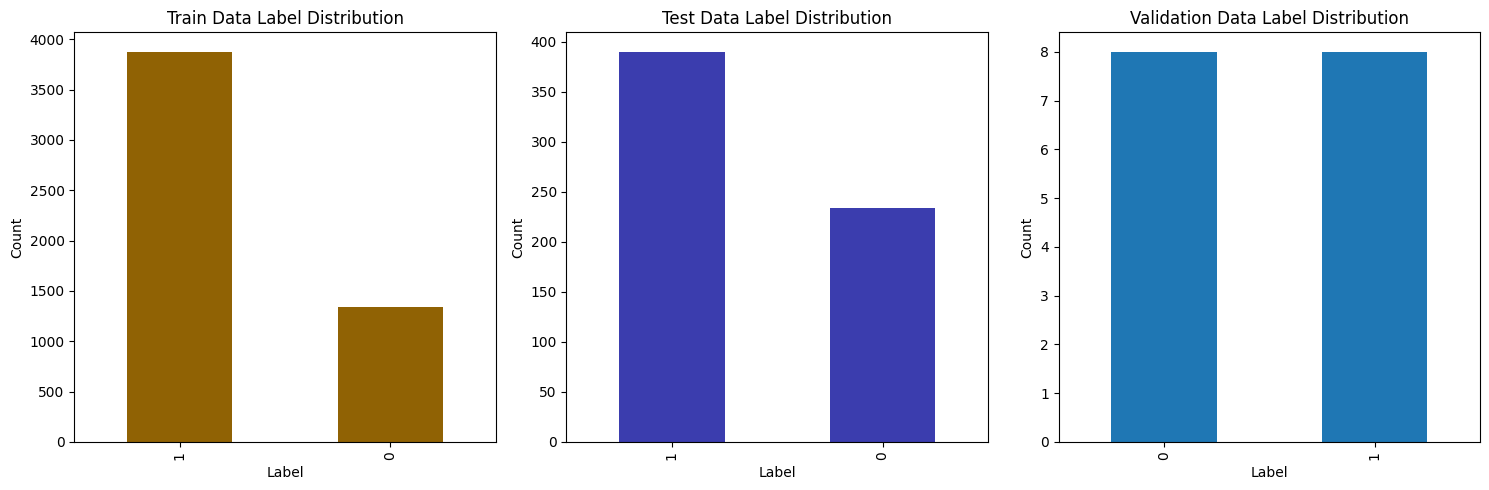

In [118]:
def plot_label_distribution(df_train, df_test, df_val):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Train data distribution
    df_train['label'].value_counts().plot(kind='bar', ax=axes[0], color=np.random.rand(3))
    axes[0].set_title('Train Data Label Distribution')
    axes[0].set_xlabel('Label')
    axes[0].set_ylabel('Count')

    # Test data distribution
    df_test['label'].value_counts().plot(kind='bar', ax=axes[1], color=np.random.rand(3))
    axes[1].set_title('Test Data Label Distribution')
    axes[1].set_xlabel('Label')
    axes[1].set_ylabel('Count')

    # Validation data distribution
    df_val['label'].value_counts().plot(kind='bar', ax=axes[2])
    axes[2].set_title('Validation Data Label Distribution')
    axes[2].set_xlabel('Label')
    axes[2].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

plot_label_distribution(df_train, df_test, df_val)


## **Reshape the loaded images**

## `preprocess_data` Funktion Übersicht

Die Funktion `preprocess_data` verarbeitet die Bild- und Label-Daten, indem sie die Bilder in das richtige Format bringt und das Dataset zufällig durchmischt.

### Prozess:
1. **Bilder umwandeln**: Die Bilder aus dem DataFrame werden in ein 4D-Array umgewandelt (`(Anzahl, img_size, img_size, chanel_nbr)`) und in `float32` konvertiert.
2. **Labels extrahieren**: Die Labels werden als NumPy-Array gespeichert.
3. **Shuffling**: Die Daten werden zufällig gemischt, um eine gleichmäßig verteilte Reihenfolge sicherzustellen.

### Anwendung:
Die Funktion wird auf Trainings-, Validierungs- und Testdaten angewendet:
```python
X_train, y_train = preprocess_data(df_train, img_size)
X_val, y_val = preprocess_data(df_val, img_size)
X_test, y_test = preprocess_data(df_test, img_size)


In [119]:
def preprocess_data(df, img_size):
    """Preprocess images and labels: reshape images and shuffle dataset."""
    X = np.stack(df['image'].to_numpy()).reshape(-1, img_size, img_size, chanel_nbr).astype(np.float32)
    y = df['label'].to_numpy()
    return shuffle(X, y, random_state=42)

# Apply function to training, validation, and test sets
X_train, y_train = preprocess_data(df_train, img_size)
X_val, y_val = preprocess_data(df_val, img_size)
X_test, y_test = preprocess_data(df_test, img_size)

In [120]:
print(f"Train shape: X={X_train.shape}), y={y_train.shape}")
print(f"Val shape: X={X_val.shape}), y={y_val.shape}")
print(f"Test shape: X={X_test.shape}), y={y_test.shape}")

Train shape: X=(5216, 224, 224, 3)), y=(5216,)
Val shape: X=(16, 224, 224, 3)), y=(16,)
Test shape: X=(624, 224, 224, 3)), y=(624,)


# Modellbewertung – Performance Evaluation

Nach dem Training des Modells wird dessen Leistung anhand verschiedener Metriken bewertet.

## 1. Youden’s J Statistic (Maximizing Sensitivity + Specificity)
Youden’s J statistic finds the threshold that maximizes the difference between True Positive Rate (TPR) and False Positive Rate (FPR):

$$
J = TPR - FPR
$$

## 2. Minimizing Distance to (0,1) in ROC Space
This method selects the threshold closest to the top-left corner (Perfect Classification). The distance is calculated as:

$$
\text{distance} = \sqrt{(1 - TPR)^2 + (FPR)^2}
$$

## 3. Maximizing F1-Score
Since F1-score balances Precision and Recall, we select the threshold that maximizes:

$$
F1 = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

​



- Youden’s J → Best if equal importance is given to Sensitivity & Specificity
- Min Distance to (0,1) → Best for models requiring high accuracy
- Max F1-Score → Best for imbalanced data, where Precision-Recall trade-off matters

In [121]:
def optimal_threshold_youden(y_test, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    youden_index = tpr - fpr  # Calculate J statistic
    best_threshold = thresholds[np.argmax(youden_index)]  # Get best threshold
    return best_threshold

def optimal_threshold_f1(y_test, y_pred_prob):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    f1_scores = (2 * precision * recall) / (precision + recall + 1e-6)  # Avoid division by zero
    best_threshold = thresholds[np.argmax(f1_scores)]  # Best threshold for max F1
    return best_threshold

def optimal_threshold_distance(y_test, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    distances = np.sqrt((1 - tpr)**2 + fpr**2)  # Compute distances
    best_threshold = thresholds[np.argmin(distances)]  # Find min distance
    return best_threshold


In [122]:
def evaluate_model(y_test, y_pred_prob, history, threshold):
    """
    Evaluates a trained model by plotting the confusion matrix, ROC curve, loss curves, 
    and printing the classification report.

    Args:
        model: Trained Keras model.
        X_test: Test dataset features.
        y_test: True labels.
        y_prob_pred : probabilitstische prognose
        history: Training history from model.fit().
        threshold: Decision threshold for classification (default=0.4).
    """
    # 1. Vorhersagen filtern
    y_pred = (y_pred_prob > threshold).astype(int)

    print(f"Optimal Threshold : {threshold}")

    # 2. Klassifikationsbericht
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # 3. Konfusionsmatrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(15, 5))

    # Plot 1: Konfusionsmatrix
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")

    # 4. ROC-Kurve und AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot 2: ROC-Kurve
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # 5. Trainings- und Validierungsverlust
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

# Visualisieren von X-Ray Bild mit Vorhersage

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(index, threshold, y_pred_prob, y_test, X_test, img_size=224):
    """Visualizes a predicted image and its label.

    Args:
        index: position of an image in the dataset.
        threshold: the threshold value for binary classification.
        y_pred_prob: probability values for predictions.
        y_test: the true labels of the test set.
        X_test: the test images stored as an array.
        img_size: the size to reshape the image (default 224x224).
    """
    # Get the image, true label, and predicted label
    image = X_test[index]
    true_label = y_test[index]
    
    # Convert prediction probability to binary label
    y_pred = (y_pred_prob > threshold).astype(int)
    predicted_label = y_pred[index]

    # Check if the image has 3 channels (RGB)
    if image.shape[-1] == 3:
        # If the image has 3 channels, convert it to grayscale (using average of the channels)
        image = np.mean(image, axis=-1)  # Convert to grayscale by averaging RGB channels

    # Reshape and display the image
    plt.imshow(image.reshape(img_size, img_size), cmap='gray')
    
    # Convert labels to human-readable form
    true_label = 'Normal' if true_label == 0 else 'Pneumonia'
    predicted_label = 'Normal' if predicted_label == 0 else 'Pneumonia'
    
    plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    plt.axis('off')
    plt.show()

### Build CNN model from keras

## Berechnung der Klassen-Gewichte

Um das Ungleichgewicht zwischen den Klassen im Datensatz auszugleichen, werden Klassen-Gewichte berechnet und angepasst.

### Automatische Berechnung der Gewichte:
Die Funktion `compute_class_weight` berechnet automatisch die Gewichte für jede Klasse basierend auf ihrer Häufigkeit im Trainingsdatensatz.

## `build_cnn_model` – CNN-Modell für Pneumonie-Klassifikation

Diese Funktion erstellt ein einfaches Convolutional Neural Network (CNN) zur Klassifikation von Lungenentzündungen anhand von Röntgenbildern.

### Architektur des Modells:
1. **Faltungs- und Pooling-Schichten:**
   - Drei **Conv2D**-Schichten mit **ReLU**-Aktivierung und **MaxPooling** zur Extraktion von Bildmerkmalen.
   - Erste Schicht mit **32 Filtern**, zweite mit **64**, dritte mit **128**.

2. **Fully Connected Layer:**
   - Eine **dichte Schicht mit 128 Neuronen** und **ReLU**-Aktivierung.
   - **Dropout (0.5)** zur Vermeidung von Overfitting.

3. **Ausgabeschicht:**
   - Eine **sigmoid-aktivierte Dense-Schicht** für die binäre Klassifikation (Pneumonie vs. Normal).




In [124]:
classes = np.array([0, 1])
class_weights = compute_class_weight('balanced', classes=classes, y=df_train['label'])
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
# specifie your customize weight for each class
# class_weights_dict = {0: 1, 1: 6}

In [125]:
def build_cnn_model(input_shape):
    """Builds a CNN model for pneumonia classification."""
    model = keras.Sequential([
        layers.Conv2D(32, (5, 5), activation='relu', padding="same", input_shape=input_shape), #  layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Add dropout for regularization
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    return model


### Formel der Binären Kreuzentropie-Verlustfunktion

Die binäre Kreuzentropie (Log-Verlust) Funktion ist wie folgt definiert:

$$
\text{Loss} = -\frac{1}{N} \sum_{i=1}^{N} \left[y_i \log(p_i) + (1 - y_i) \log(1 - p_i)\right]
$$

Wo:

\( y_i \) = Tatsächliches Label (0 oder 1)  
 \( p_i \) = Vom Modell vorhergesagte Wahrscheinlichkeit  
\( N \) = Gesamtzahl der Proben  

Diese Funktion misst die Differenz zwischen der echten Klasse (\( y_i \)) und der vorhergesagten Wahrscheinlichkeit (\( p_i \)).  
Sie bestraft stark falsche Vorhersagen, besonders wenn \( p_i \) nahe 0 oder 1 liegt.  

**Ziel**: Minimieren des Verlusts, um die Modellleistung zu verbessern.




In [126]:
# Build the model
model = build_cnn_model(input_shape=(img_size, img_size, chanel_nbr))

# Compile the model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), #tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.8),  #tf.keras.optimizers.Adam(learning_rate=0.0001),  #
              loss='binary_crossentropy',   # tfa.losses.SigmoidFocalCrossEntropy()
              metrics=['accuracy'])


# Train the model
history = model.fit(X_train, y_train, epochs=20,
                    class_weight=class_weight_dict,
                    validation_data=(X_val, y_val),
                    batch_size=32)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 825ms/step - accuracy: 0.6614 - loss: 0.5542 - val_accuracy: 0.8125 - val_loss: 0.3317
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 160s 981ms/step - accuracy: 0.9289 - loss: 0.1805 - val_accuracy: 0.9375 - val_loss: 0.2426
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9541 - loss: 0.1278 - val_accuracy: 0.8750 - val_loss: 0.1952
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 154s 944ms/step - accuracy: 0.9572 - loss: 0.1186 - val_accuracy: 0.8750 - val_loss: 0.1406
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 156s 959ms/step - accuracy: 0.9659 - loss: 0.0992 - val_accuracy: 0.9375 - val_loss: 0.1517
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 148s 909ms/step - accuracy: 0.9665 - loss: 0.0873 - val_accuracy: 0.9375 - val_loss: 0.1259
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 156s 958ms/step - accuracy: 0.9655 - loss: 0.0874 - val_accuracy: 0.8125 - val_loss: 0.2236
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 159s 978ms/step - accuracy: 0.9714 - lo

## Speichern des trainierten Modells mit `joblib`

Um das trainierte CNN-Modell zu speichern und später wiederzuverwenden, kann die Bibliothek `joblib` verwendet werden.

In [127]:
#save moel
joblib.dump(model, "cnn_pneumonia_model.pkl")

['cnn_pneumonia_model.pkl']

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step
Optimal Threshold : 0.9999545216560364
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       234
           1       0.92      0.87      0.89       390

    accuracy                           0.87       624
   macro avg       0.86      0.87      0.86       624
weighted avg       0.87      0.87      0.87       624



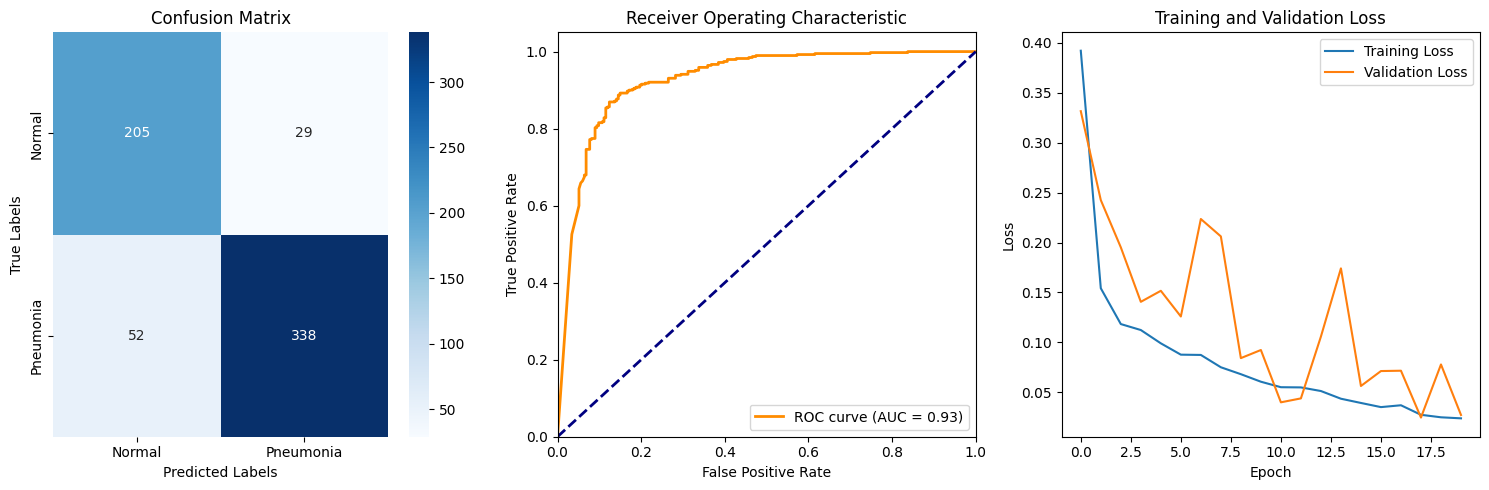

In [128]:
#evaluate trained model
y_pred_prob = model.predict(X_test)
# Compute optimal threshold
best_thresh = optimal_threshold_youden(y_test, y_pred_prob)
evaluate_model(y_test=y_test, y_pred_prob=y_pred_prob,history=history, threshold=best_thresh)

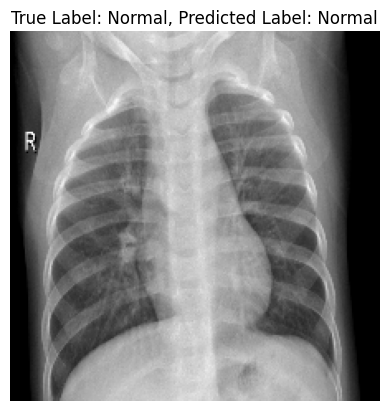

In [102]:
# Choose a random index
index = np.random.randint(0, len(X_test))
# Visualize the prediction
visualize_prediction(index, best_thresh, y_pred_prob, y_test, X_test)

# Model Training with Augmented Data

In this section, we build a CNN model, compile it, and apply data augmentation to address the class imbalance in the dataset. We perform the following steps:

In [129]:
def augment_minority_class(X, y, img_size, chanel_nbr):
    """
    Augments the minority class in the dataset using random oversampling and image transformations.

    Args:
        X: The image data (NumPy array).
        y: The labels (NumPy array).
        img_size: Size of images

    Returns:
        Tuple: Augmented image data (X_augmented) and labels (y_augmented).
    """

    ros = RandomOverSampler(random_state=42) 
    X_resampled, y_resampled = ros.fit_resample(X.reshape(X.shape[0], -1), y)
    X_augmented = X_resampled.reshape(-1, img_size, img_size, chanel_nbr)

    for i in range(X_augmented.shape[0]):
        if np.random.rand() > 0.5:
            angle = np.random.randint(-15, 15)
            M = cv2.getRotationMatrix2D((img_size / 2, img_size / 2), angle, 1)

            if chanel_nbr == 1:
                # ✅ Grayscale: Apply transformation directly
                X_augmented[i, :, :, 0] = cv2.warpAffine(X_augmented[i, :, :, 0], M, (img_size, img_size))
            else:
                # ✅ RGB: Process each channel separately
                for c in range(chanel_nbr):
                    X_augmented[i, :, :, c] = cv2.warpAffine(X_augmented[i, :, :, c], M, (img_size, img_size))

        if np.random.rand() > 0.5:
            X_augmented[i] = cv2.flip(X_augmented[i], 1)  # ✅ Flip horizontally

    return X_augmented, y_resampled

In [130]:
# Build the model
model = build_cnn_model(input_shape=(img_size, img_size, chanel_nbr))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

X_train_augmented, y_train_augmented = augment_minority_class(X_train, y_train, img_size, chanel_nbr)

print(f"Original train shape: X={X_train.shape}), y={y_train.shape}")
print(f"Augmented train shape: X={X_train_augmented.shape}), y={y_train_augmented.shape}")


# Retrain the model with augmented data
history = model.fit(X_train_augmented, y_train_augmented,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    batch_size=32)


Original train shape: X=(5216, 224, 224, 3)), y=(5216,)
Augmented train shape: X=(7750, 224, 224, 3)), y=(7750,)
Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.7492 - loss: 0.5330 - val_accuracy: 0.6250 - val_loss: 0.8100
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 234s 961ms/step - accuracy: 0.9367 - loss: 0.1639 - val_accuracy: 0.9375 - val_loss: 0.1484
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.9600 - loss: 0.1197 - val_accuracy: 0.7500 - val_loss: 0.6793
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 233s 959ms/step - accuracy: 0.9629 - loss: 0.0967 - val_accuracy: 0.8750 - val_loss: 0.3947
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.9772 - loss: 0.0673 - val_accuracy: 1.0000 - val_loss: 0.0423
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.9748 - loss: 0.0664 - val_accuracy: 0.7500 - val_loss: 1.5534
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.9844 - loss: 0.0504 - val_accuracy: 0.81

In [18]:
#save moel
joblib.dump(model, "augmented_data_cnn_pneumonia_model.pkl")

['augmented_data_cnn_pneumonia_model.pkl']

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step
Optimal Threshold : 0.9936503767967224
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84       234
           1       0.89      0.92      0.91       390

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624



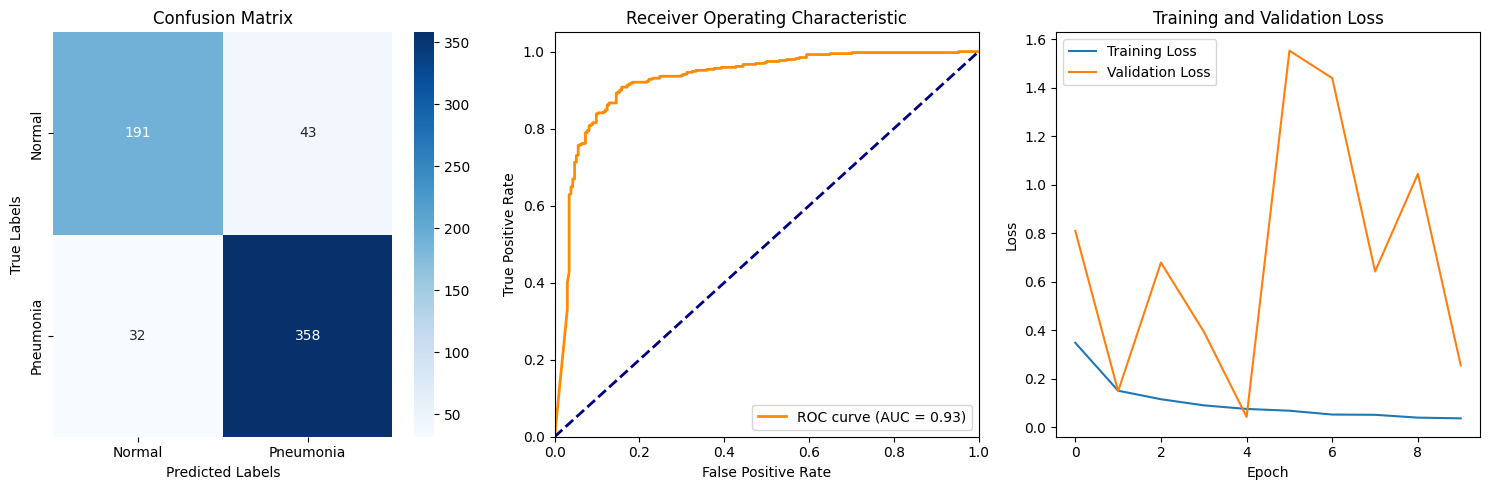

In [131]:
#evaluate trained model
y_pred_prob = model.predict(X_test)
# Compute optimal threshold
best_thresh = optimal_threshold_f1(y_test, y_pred_prob)
evaluate_model(y_test=y_test, y_pred_prob=y_pred_prob,history=history, threshold=best_thresh)

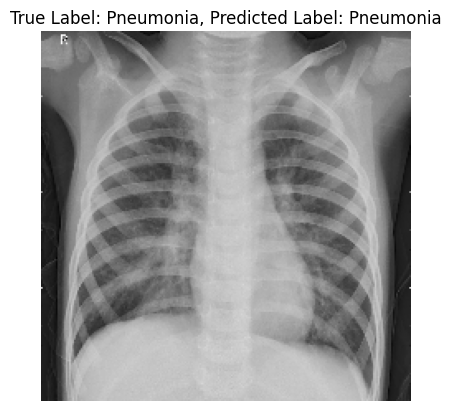

In [38]:
# Visualize the prediction
index = np.random.randint(0, len(X_test))
visualize_prediction(index, best_thresh, y_pred_prob, y_test, X_test)

# Fine-Tuning a Pre-trained ResNet50 Model for Binary Classification

In this section, we use a pre-trained **ResNet50** model, which is fine-tuned to solve a binary classification problem (e.g., **Pneumonia vs Normal**).

**Load Pre-trained ResNet50 Model**:
   - We load the **ResNet50** model pre-trained on **ImageNet** without the final classification layer (`include_top=False`).
   - The input shape is set to `(img_size, img_size, chanel_nbr)`, where `img_size` is the desired size of the images, and `chanel_nbr` is the number of color channels (1 for grayscale or 3 for RGB).

   ```python
   base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(img_size, img_size, chanel_nbr))

- ResNet50 is used as the base model with the top layers removed.
- The model is fine-tuned by unfreezing the last 30 layers to adapt to the binary classification task (Pneumonia vs Normal).
- A custom head is added to output a single sigmoid value for binary classification.
- The model is trained with a low learning rate and binary cross-entropy loss.

In [133]:
# Charger le modèle pré-entraîné (sans la dernière couche)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(img_size, img_size, chanel_nbr))

# Geler les poids du modèle pré-entraîné
base_model.trainable = False

# Unfreeze some layers of the base model
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers first

# Fine-tune the top layers (last few blocks of ResNet50)
#for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
#    layer.trainable = True


# add customise layer by the output
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x) # 1 because of binary class (Pneumonia vs Normal)

# final model definition
model = Model(inputs=base_model.input, outputs=output)

# compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model summary
#model.summary()
history = model.fit(X_train, 
                    y_train,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    batch_size=32)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.7122 - loss: 0.6151 - val_accuracy: 0.5000 - val_loss: 0.8529
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.7387 - loss: 0.5816 - val_accuracy: 0.5000 - val_loss: 0.7758
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.7395 - loss: 0.5614 - val_accuracy: 0.5000 - val_loss: 0.8232
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.7527 - loss: 0.5479 - val_accuracy: 0.5000 - val_loss: 0.7795
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.7412 - loss: 0.5469 - val_accuracy: 0.5000 - val_loss: 0.8226
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.7494 - loss: 0.5402 - val_accuracy: 0.5000 - val_loss: 0.7999
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.7411 - loss: 0.5486 - val_accuracy: 0.5000 - val_loss: 0.8051
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.7435 - loss: 0.5380 - val_accu

In [134]:
#save moel
joblib.dump(model, "resNet50_pneumonia_model.pkl")

['resNet50_pneumonia_model.pkl']

In [135]:
y_pred_prob = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step


Optimal Threshold : 0.7444919347763062
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.72      0.71       234
           1       0.83      0.81      0.82       390

    accuracy                           0.78       624
   macro avg       0.76      0.77      0.76       624
weighted avg       0.78      0.78      0.78       624



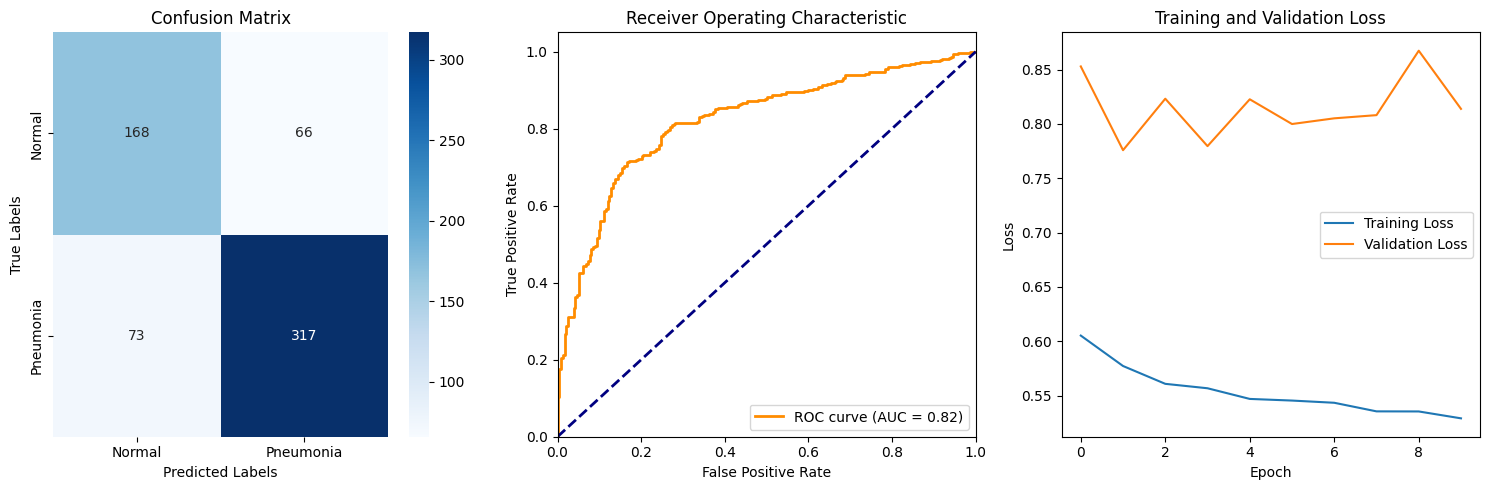

In [136]:
best_threshold = optimal_threshold_f1(y_test, y_pred_prob)
evaluate_model(y_test=y_test, y_pred_prob=y_pred_prob,history=history, threshold=best_threshold)

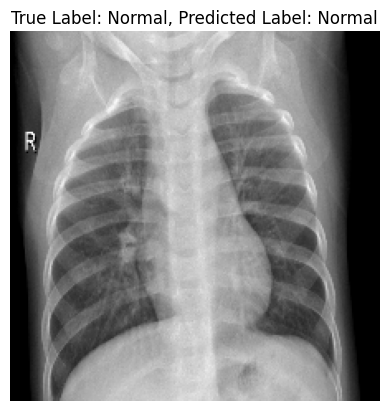

In [137]:
# Visualize the prediction
visualize_prediction(index, best_threshold, y_pred_prob, y_test, X_test, img_size)